In [1]:
!pip3 install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import relevant libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
from IPython.display import display
# filter warnings
warnings.filterwarnings('ignore')

In [4]:
#Import relevant libraries for building the models
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical
import cv2
import numpy as np
from keras.layers import Dense, Flatten
from glob import glob

In [159]:
X = np.load('/content/drive/MyDrive/breast_cancer/X.npy') # images
Y = np.load('/content/drive/MyDrive/breast_cancer/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

##**Data Analysis**##

In [22]:
print(X)

[[[[226 164 206]
   [224 154 196]
   [225 175 211]
   ...
   [240 221 237]
   [232 184 214]
   [243 213 235]]

  [[217 142 188]
   [221 130 179]
   [224 150 196]
   ...
   [227 170 204]
   [229 180 215]
   [236 212 232]]

  [[237 178 212]
   [229 157 199]
   [218 125 175]
   ...
   [221 184 217]
   [190 153 193]
   [227 164 208]]

  ...

  [[217 145 192]
   [214 129 184]
   [212 129 183]
   ...
   [194 122 185]
   [204 143 193]
   [189 129 188]]

  [[218 144 192]
   [213 128 185]
   [208 121 171]
   ...
   [136  79 145]
   [184 111 174]
   [188 112 176]]

  [[212 125 181]
   [211 136 181]
   [220 162 206]
   ...
   [127  90 152]
   [213 167 202]
   [215 180 211]]]


 [[[219 150 197]
   [217 158 201]
   [228 173 205]
   ...
   [198 165 199]
   [230 204 224]
   [231 193 221]]

  [[223 150 195]
   [222 140 192]
   [213 133 186]
   ...
   [218 143 193]
   [218 148 197]
   [215 131 185]]

  [[203 125 176]
   [218 143 192]
   [227 163 199]
   ...
   [210 137 188]
   [203 121 177]
   [192 124

In [23]:
print(Y) #Exploring the labels associated to images in this dataset (0 = no IDC, 1 = IDC)

[0 0 0 ... 1 1 1]


In [24]:
#Printing dimensions of dataset
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (5547, 50, 50, 3)
Y shape:  (5547,)


In [76]:
missing_values_in_X = np.isnan(X).any() #Check for missing values in the image data X
missing_values_in_Y = np.isnan(Y).any() #Check for missing values in the labels Y

print(missing_values_in_X)
print(missing_values_in_Y)

False
False


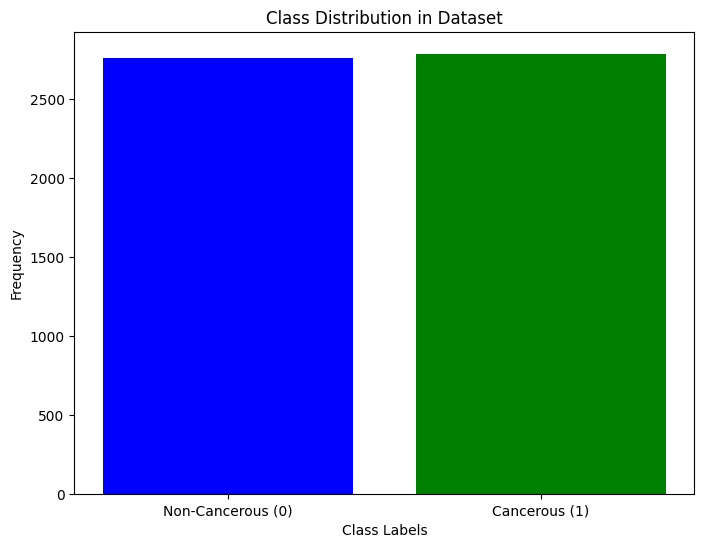

In [160]:
#Check for imbalance in the Dataset
unique, counts = np.unique(Y, return_counts=True)
class_counts = dict(zip(unique, counts))
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green'])
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Dataset')
plt.xticks(ticks=[0, 1], labels=['Non-Cancerous (0)', 'Cancerous (1)'])
plt.show()

In [25]:
def plot_images(X, Y, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, ax in enumerate(axes):
        #Randomly pick an image and display it
        idx = np.random.randint(0, X.shape[0])
        ax.imshow(X[idx])
        ax.set_title('Label: ' + str(Y[idx]))
        ax.axis('off')

    plt.show()

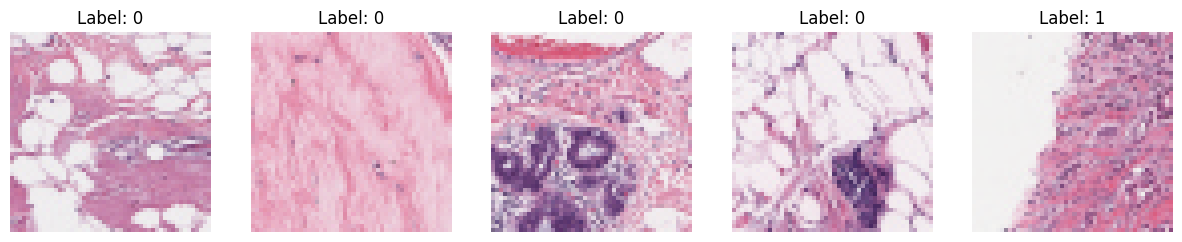

In [26]:
plot_images(X, Y, num_images=5)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_image_display(X, Y):
    def view_image(index):
        plt.imshow(X[index])
        plt.title('IDC Present: ' + ('Yes' if Y[index] == 1 else 'No'))
        plt.axis('off')
        plt.show()


    index_slider = widgets.IntSlider(value=0, min=0, max=len(X) - 1, step=1, description='Image Index')
    widgets.interact(view_image, index=index_slider)

interactive_image_display(X, Y)

interactive(children=(IntSlider(value=0, description='Image Index', max=5546), Output()), _dom_classes=('widge…

In [161]:
import numpy as np

# Assuming X is your image array with shape (5547, 50, 50, 3)

# Calculate the mean for each channel
red_mean = np.mean(X[:, :, :, 0])
green_mean = np.mean(X[:, :, :, 1])
blue_mean = np.mean(X[:, :, :, 2])

# Calculate the standard deviation for each channel
red_std = np.std(X[:, :, :, 0])
green_std = np.std(X[:, :, :, 1])
blue_std = np.std(X[:, :, :, 2])

# Calculate the minimum value for each channel
red_min = np.min(X[:, :, :, 0])
green_min = np.min(X[:, :, :, 1])
blue_min = np.min(X[:, :, :, 2])

# Calculate the maximum value for each channel
red_max = np.max(X[:, :, :, 0])
green_max = np.max(X[:, :, :, 1])
blue_max = np.max(X[:, :, :, 2])

# Print all results in a concise format
print(f"Mean values for each channel: R = {red_mean:.2f}, G = {green_mean:.2f}, B = {blue_mean:.2f}")
print(f"Standard deviation for each channel: R = {red_std:.2f}, G = {green_std:.2f}, B = {blue_std:.2f}")
print(f"Minimum values for each channel: R = {red_min}, G = {green_min}, B = {blue_min}")
print(f"Maximum values for each channel: R = {red_max}, G = {green_max}, B = {blue_max}")

Mean values for each channel: R = 205.79, G = 161.87, B = 187.44
Standard deviation for each channel: R = 36.29, G = 53.94, B = 38.69
Minimum values for each channel: R = 4, G = 2, B = 5
Maximum values for each channel: R = 255, G = 255, B = 255


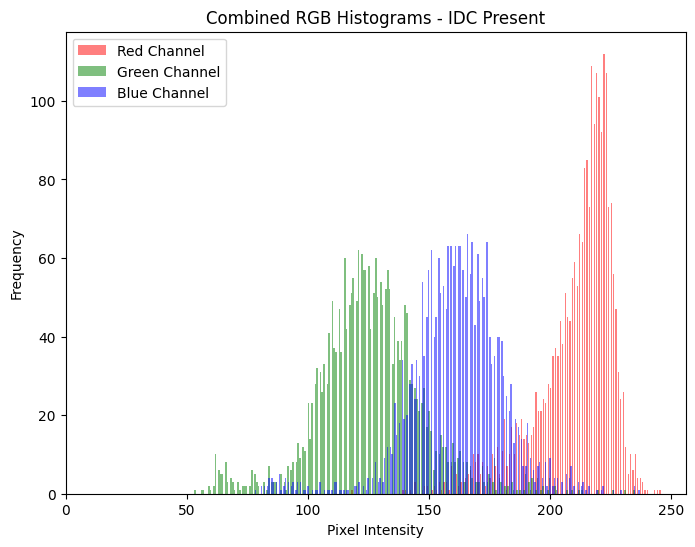

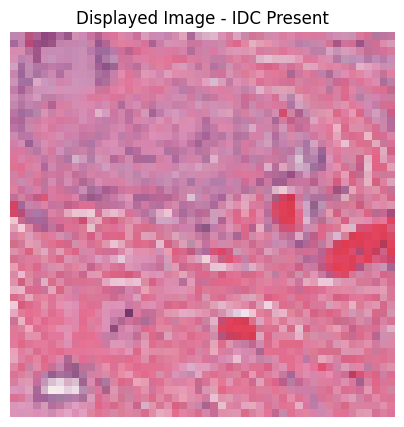

In [32]:
def plot_combined_rgb_histograms(X, Y):
    #Select a random image
    idx = np.random.randint(0, X.shape[0])
    image = X[idx]
    label = Y[idx]
    label_text = 'IDC Present' if label == 1 else 'No IDC'
    plt.figure(figsize=(8, 6))

    #Colors and labels for each channel
    colors = ['red', 'green', 'blue']
    channel_labels = ['Red Channel', 'Green Channel', 'Blue Channel']

    #Plot histograms for each channel
    for i, color in enumerate(colors):
        plt.hist(image[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=channel_labels[i])

    plt.title(f'Combined RGB Histograms - {label_text}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.xlim([0, 256])
    plt.legend()

    plt.show()

    #Display the selected image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f'Displayed Image - {label_text}')
    plt.axis('off')
    plt.show()

plot_combined_rgb_histograms(X, Y)

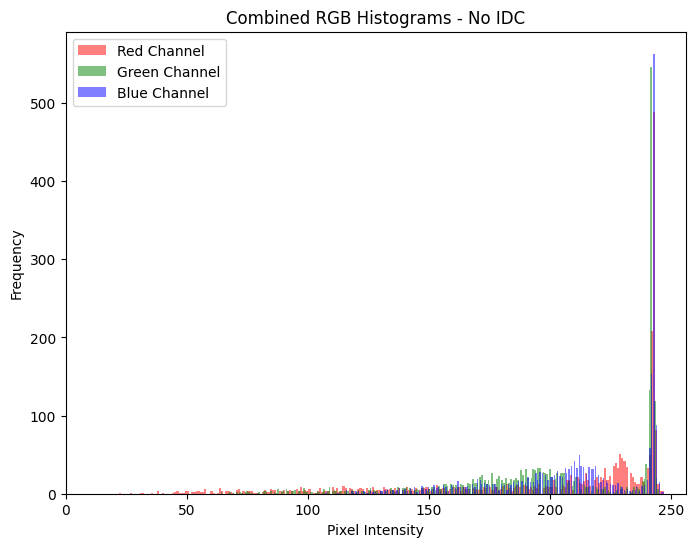

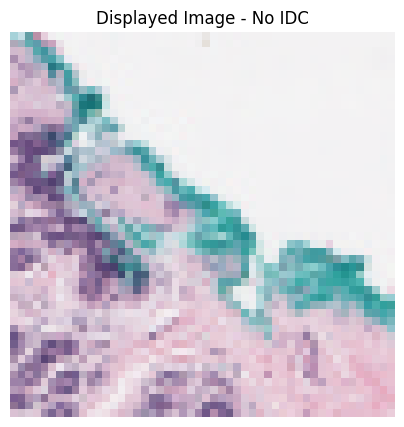

In [33]:
plot_combined_rgb_histograms(X, Y)

##**Data Splitting**

In [129]:
from sklearn.model_selection import train_test_split
# Normalize the image data
X_normalized = X.astype('float32') / 255.0

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)

In [130]:
numberoftrain = xtrain.shape[0] #Number of rows of data in numberoftrain
numberoftest = xtest.shape[0] #Number of rows of data in numberoftest
xtrain.shape #Dimensions of xtrain

(3882, 50, 50, 3)

In [132]:
#Reshape Xtrain & Xtest (only used for models other than Neural Networks)

xtrain = xtrain.reshape(numberoftrain,xtrain.shape[1]*xtrain.shape[2]*xtrain.shape[3]) #Total number of elements in each image of the xtest dataset after flattening. It calculates the product of the number of rows, the number of columns, and the number of channels in the image.
xtest = xtest.reshape(numberoftest,xtest.shape[1]*xtest.shape[2]*xtest.shape[3]) #Total number of elements in each image of the xtest dataset after flattening. It calculates the product of the number of rows, the number of columns, and the number of channels in the image.
print("X Train: ",xtrain.shape)
print("X Test: ",xtest.shape)

X Train:  (3882, 7500)
X Test:  (1665, 7500)


In [48]:
len(ytest)

1665

In [49]:
len(ytrain)

3882

##**Basic Neural Network**

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [80]:
#The split done above will not be used for the Basic Neural Network
X = np.load('/content/drive/MyDrive/breast_cancer/X.npy') # images
Y = np.load('/content/drive/MyDrive/breast_cancer/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

#Normalize the image data to be between 0 and 1
X_normalized = X.astype('float32') / 255.0

#Flatten the images to 1D since we're not using convolutional layers
X_flattened = X_normalized.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y, test_size=0.3, random_state=42)

In [81]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer + hidden layer with 128 units
    Dense(1, activation='sigmoid')  # Output layer with a single neuron and sigmoid activation
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
122/122 [==============================] - 3s 23ms/step - loss: 0.7874 - accuracy: 0.5868 - val_loss: 0.7925 - val_accuracy: 0.4991
Epoch 2/10
122/122 [==============================] - 3s 24ms/step - loss: 0.6586 - accuracy: 0.6329 - val_loss: 0.7160 - val_accuracy: 0.5916
Epoch 3/10
122/122 [==============================] - 3s 28ms/step - loss: 0.6122 - accuracy: 0.6762 - val_loss: 0.5650 - val_accuracy: 0.7345
Epoch 4/10
122/122 [==============================] - 2s 19ms/step - loss: 0.5728 - accuracy: 0.7058 - val_loss: 0.5594 - val_accuracy: 0.7177
Epoch 5/10
122/122 [==============================] - 2s 16ms/step - loss: 0.5553 - accuracy: 0.7264 - val_loss: 0.6906 - val_accuracy: 0.6354
Epoch 6/10
122/122 [==============================] - 2s 16ms/step - loss: 0.5961 - accuracy: 0.6865 - val_loss: 0.5560 - val_accuracy: 0.7207
Epoch 7/10
122/122 [==============================] - 2s 18ms/step - loss: 0.5564 - accuracy: 0.7226 - val_loss: 0.5753 - val_accuracy: 0.7003

In [83]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

53/53 [==============================] - 0s 9ms/step - loss: 0.5497 - accuracy: 0.7393
Test accuracy: 0.7393393516540527, Test loss: 0.5497421622276306


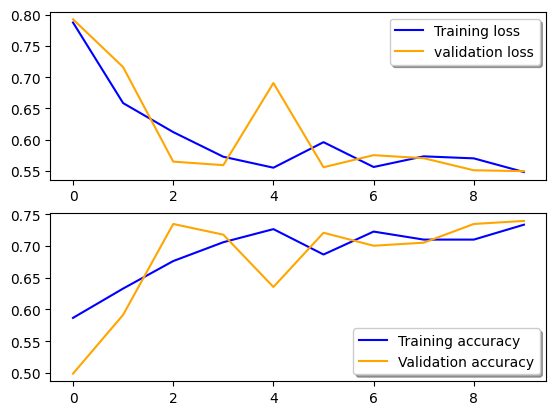

In [84]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [86]:
Y_pred = model.predict(X_test)

53/53 [==============================] - 0s 6ms/step


In [87]:
threshold = 0.5  # Threshold value to determine class membership
# Convert predicted probabilities into class labels
Y_pred_classes = np.where(Y_pred >= threshold, 1, 0)
print(Y_pred_classes)

[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [0]]


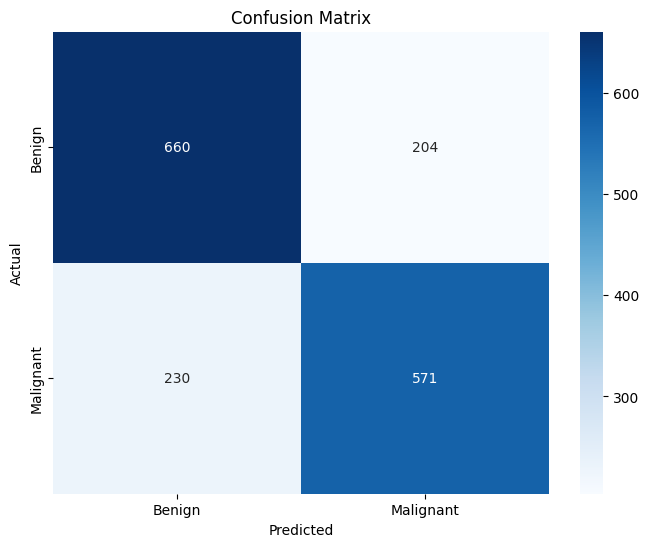

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [90]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       864
           1       0.74      0.71      0.72       801

    accuracy                           0.74      1665
   macro avg       0.74      0.74      0.74      1665
weighted avg       0.74      0.74      0.74      1665



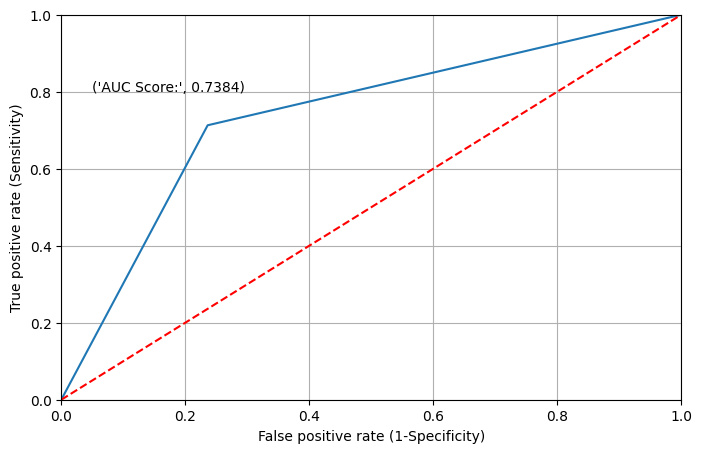

In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize']=(8,5)

fpr, tpr, thresholds = roc_curve(ytest, Y_pred_classes)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--') # r-- : Red dashed line
plt.text(x = 0.05, y = 0.8, s =('AUC Score:', round(roc_auc_score(ytest, Y_pred_classes),4)))
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

# plot the grid
plt.grid(True)

In [101]:
import pandas as pd
from sklearn import metrics

# Define columns
cols = ['Model', 'AUC Score', 'Precision Score', 'Recall Score','Accuracy Score', 'f1-score']
result_tabulation = pd.DataFrame(columns=cols)
Neural_Network = pd.DataFrame({'Model': ["Basic Neural Network"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, Y_pred_classes)],
                 'Precision Score': [metrics.precision_score(ytest, Y_pred_classes)],
                 'Recall Score': [metrics.recall_score(ytest, Y_pred_classes)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, Y_pred_classes)],
                  'f1-score': [metrics.f1_score(ytest, Y_pred_classes)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, Neural_Network], ignore_index=True)
result_tabulation


,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619


##**Convolutional Neural Network**##

In [102]:
X = np.load('/content/drive/MyDrive/breast_cancer/X.npy') # images
Y = np.load('/content/drive/MyDrive/breast_cancer/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

In [103]:
from sklearn.model_selection import train_test_split
# Normalize the image data
X_normalized = X.astype('float32') / 255.0

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)

In [104]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
#With Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), callbacks=[early_stopping])

Epoch 1/100
122/122 [==============================] - 100s 817ms/step - loss: 0.5826 - accuracy: 0.7032 - val_loss: 0.5838 - val_accuracy: 0.7087
Epoch 2/100
122/122 [==============================] - 69s 563ms/step - loss: 0.5648 - accuracy: 0.7195 - val_loss: 0.5799 - val_accuracy: 0.7141
Epoch 3/100
122/122 [==============================] - 109s 895ms/step - loss: 0.5686 - accuracy: 0.7169 - val_loss: 0.5093 - val_accuracy: 0.7682
Epoch 4/100
122/122 [==============================] - 99s 811ms/step - loss: 0.5323 - accuracy: 0.7437 - val_loss: 0.5057 - val_accuracy: 0.7622
Epoch 5/100
122/122 [==============================] - 83s 682ms/step - loss: 0.5241 - accuracy: 0.7532 - val_loss: 0.5386 - val_accuracy: 0.7315
Epoch 6/100
122/122 [==============================] - 65s 535ms/step - loss: 0.5119 - accuracy: 0.7609 - val_loss: 0.5211 - val_accuracy: 0.7532
Epoch 7/100
122/122 [==============================] - 61s 502ms/step - loss: 0.5305 - accuracy: 0.7653 - val_loss: 0.5884

In [107]:
test_loss, test_acc = model.evaluate(xtest, ytest)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

53/53 [==============================] - 6s 105ms/step - loss: 0.5057 - accuracy: 0.7622
Test accuracy: 0.7621621489524841, Test loss: 0.5057265162467957


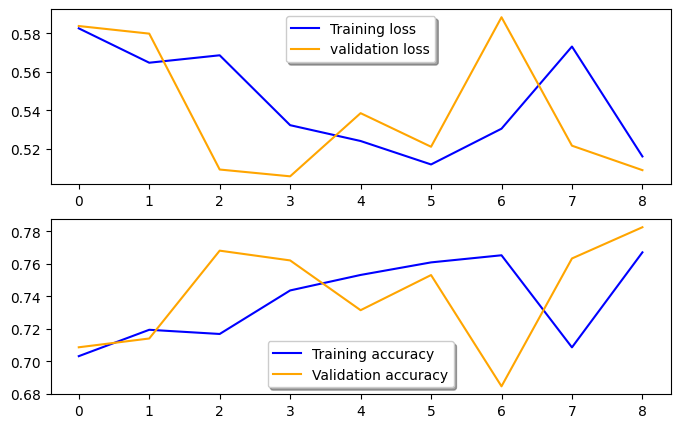

In [108]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [109]:
Y_pred = model.predict(xtest)

53/53 [==============================] - 5s 101ms/step


In [110]:
threshold = 0.5  # Threshold value to determine class membership
# Convert predicted probabilities into class labels
Y_pred_classes = np.where(Y_pred >= threshold, 1, 0)
print(Y_pred_classes)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


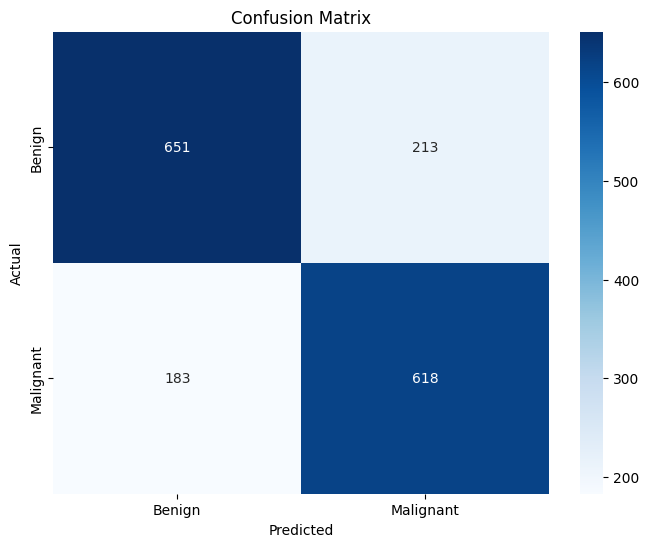

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [112]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.78      0.75      0.77       864
           1       0.74      0.77      0.76       801

    accuracy                           0.76      1665
   macro avg       0.76      0.76      0.76      1665
weighted avg       0.76      0.76      0.76      1665



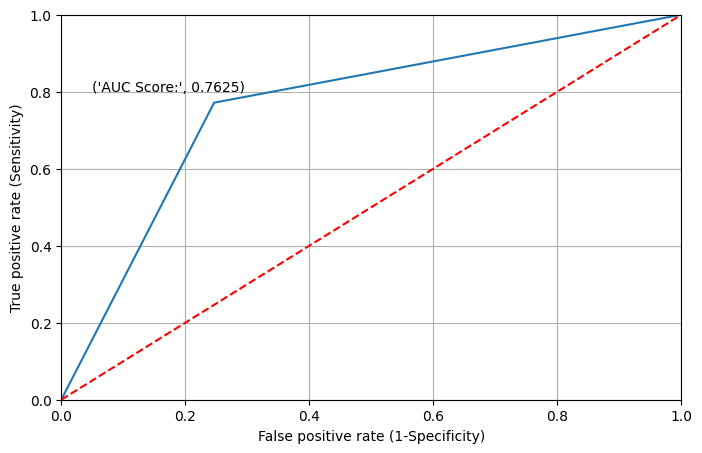

In [113]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize']=(8,5)

fpr, tpr, thresholds = roc_curve(ytest, Y_pred_classes)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--') # r-- : Red dashed line
plt.text(x = 0.05, y = 0.8, s =('AUC Score:', round(roc_auc_score(ytest, Y_pred_classes),4)))
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

# plot the grid
plt.grid(True)

In [114]:
CNN = pd.DataFrame({'Model': ["Convolutional Neural Network"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, Y_pred_classes)],
                 'Precision Score': [metrics.precision_score(ytest, Y_pred_classes)],
                 'Recall Score': [metrics.recall_score(ytest, Y_pred_classes)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, Y_pred_classes)],
                  'f1-score': [metrics.f1_score(ytest, Y_pred_classes)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, CNN], ignore_index=True)
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353


##**Transfer Learning**##

In [115]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [116]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
base_model.trainable = False  # Freeze the convolutional base to prevent its weights from being updated during training

In [117]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
model = Model(inputs=base_model.input, outputs=predictions)

In [118]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(xtrain, ytrain, epochs=10, validation_data=(xtest, ytest))

Epoch 1/10
122/122 [==============================] - 213s 2s/step - loss: 0.6100 - accuracy: 0.6628 - val_loss: 0.5970 - val_accuracy: 0.6811
Epoch 2/10
122/122 [==============================] - 198s 2s/step - loss: 0.5673 - accuracy: 0.7071 - val_loss: 0.5718 - val_accuracy: 0.7207
Epoch 3/10
122/122 [==============================] - 196s 2s/step - loss: 0.5464 - accuracy: 0.7233 - val_loss: 0.5662 - val_accuracy: 0.7285
Epoch 4/10
122/122 [==============================] - 163s 1s/step - loss: 0.5373 - accuracy: 0.7298 - val_loss: 0.5760 - val_accuracy: 0.7111
Epoch 5/10
122/122 [==============================] - 197s 2s/step - loss: 0.5174 - accuracy: 0.7460 - val_loss: 0.5658 - val_accuracy: 0.7225
Epoch 6/10
122/122 [==============================] - 197s 2s/step - loss: 0.5080 - accuracy: 0.7517 - val_loss: 0.5760 - val_accuracy: 0.7123
Epoch 7/10
122/122 [==============================] - 198s 2s/step - loss: 0.4947 - accuracy: 0.7628 - val_loss: 0.5779 - val_accuracy: 0.7111

In [119]:
test_loss, test_acc = model.evaluate(xtest, ytest)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

53/53 [==============================] - 50s 939ms/step - loss: 0.5941 - accuracy: 0.7093
Test accuracy: 0.7093092799186707, Test loss: 0.5941338539123535


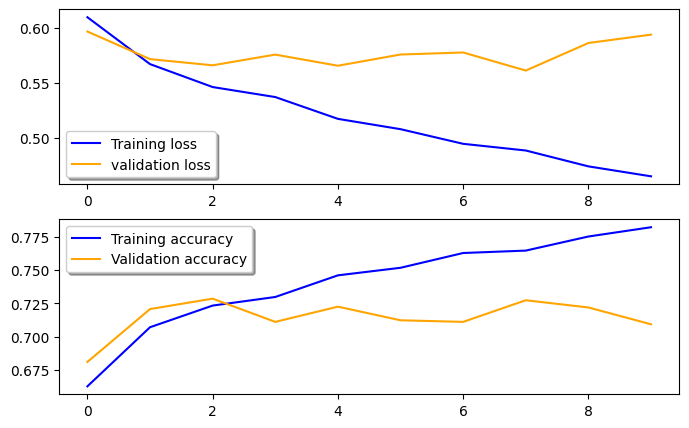

In [120]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [121]:
Y_pred = model.predict(xtest)

53/53 [==============================] - 51s 944ms/step


In [122]:
threshold = 0.5  # Threshold value to determine class membership
# Convert predicted probabilities into class labels
Y_pred_classes = np.where(Y_pred >= threshold, 1, 0)
print(Y_pred_classes)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


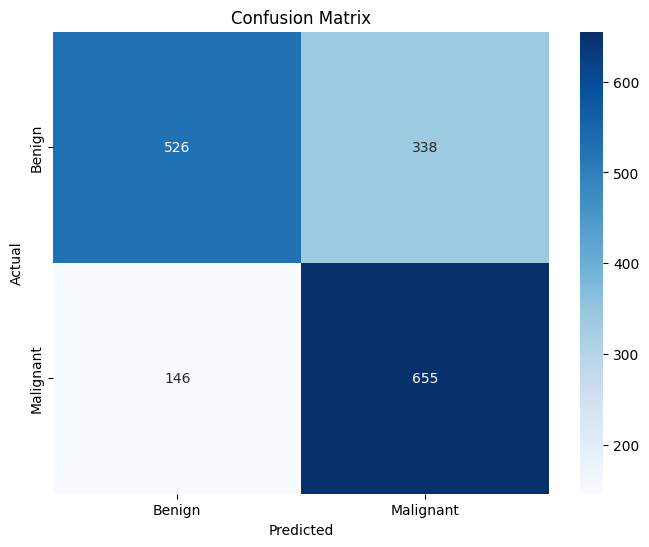

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [124]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)
print(result)

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       864
           1       0.66      0.82      0.73       801

    accuracy                           0.71      1665
   macro avg       0.72      0.71      0.71      1665
weighted avg       0.72      0.71      0.71      1665



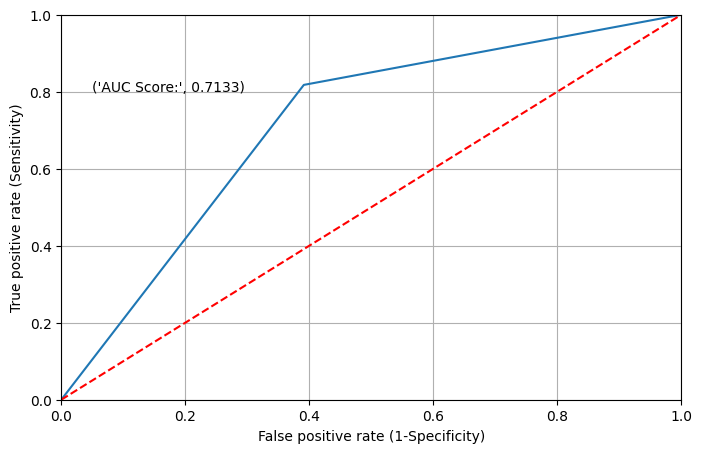

In [125]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize']=(8,5)

fpr, tpr, thresholds = roc_curve(ytest, Y_pred_classes)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--') # r-- : Red dashed line
plt.text(x = 0.05, y = 0.8, s =('AUC Score:', round(roc_auc_score(ytest, Y_pred_classes),4)))
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

# plot the grid
plt.grid(True)

In [126]:
VGG = pd.DataFrame({'Model': ["VGG-16: Transfer Learning"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, Y_pred_classes)],
                 'Precision Score': [metrics.precision_score(ytest, Y_pred_classes)],
                 'Recall Score': [metrics.recall_score(ytest, Y_pred_classes)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, Y_pred_classes)],
                  'f1-score': [metrics.f1_score(ytest, Y_pred_classes)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, VGG], ignore_index=True)
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353
2,VGG-16: Transfer Learning,0.713262,0.659617,0.817728,0.709309,0.730212


##**Decision Tree**

In [133]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier() #initialization
decision_tree= DTC.fit(xtrain,ytrain) #fits on training data

In [134]:
# predicting values
y_pred  = decision_tree.predict(xtest)

In [135]:
y_pred

array([0, 1, 1, ..., 0, 0, 0])

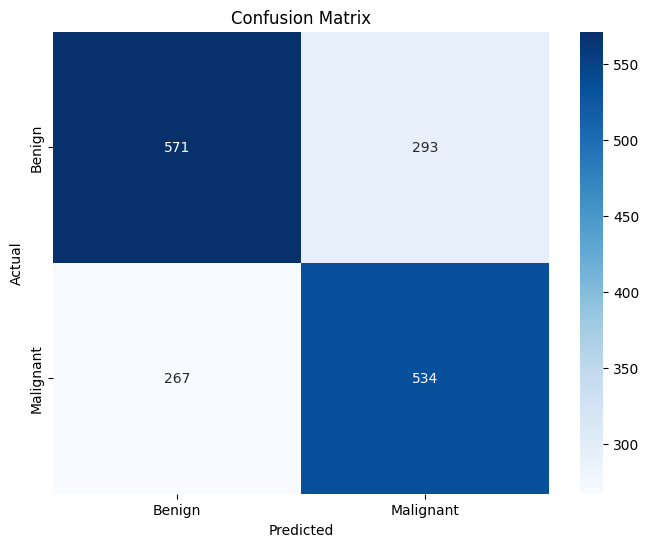

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(ytest, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [137]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       864
           1       0.66      0.82      0.73       801

    accuracy                           0.71      1665
   macro avg       0.72      0.71      0.71      1665
weighted avg       0.72      0.71      0.71      1665



In [138]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(ytest, y_pred)
precision = precision_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)  # Sensitivity
f1 = f1_score(ytest, y_pred)
roc_auc = roc_auc_score(ytest, y_pred)
# Confusion Matrix and Specificity
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Specificity: {specificity}")

Accuracy: 0.6636636636636637
Precision: 0.6457073760580411
Recall (Sensitivity): 0.6666666666666666
F1 Score: 0.656019656019656
ROC AUC Score: 0.6637731481481481
Specificity: 0.6608796296296297


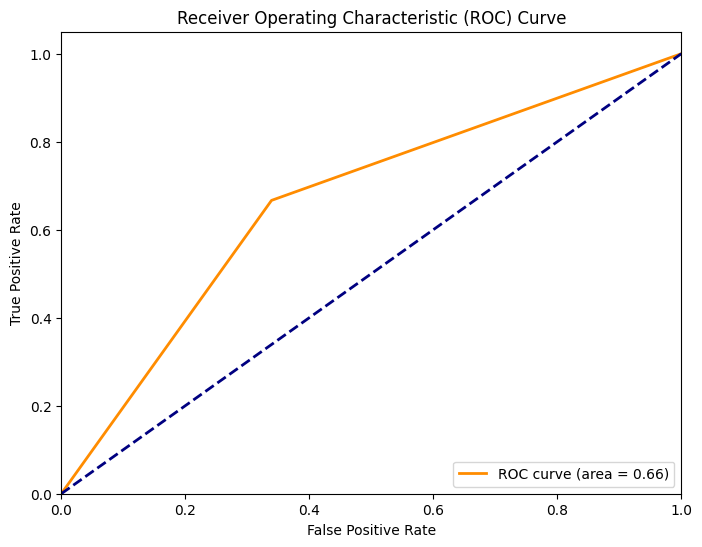

In [139]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [141]:
Decision_Tree = pd.DataFrame({'Model': ["Decision Tree"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, y_pred)],
                 'Precision Score': [metrics.precision_score(ytest, y_pred)],
                 'Recall Score': [metrics.recall_score(ytest, y_pred)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, y_pred)],
                  'f1-score': [metrics.f1_score(ytest, y_pred)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, Decision_Tree], ignore_index=True)

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353
2,VGG-16: Transfer Learning,0.713262,0.659617,0.817728,0.709309,0.730212
3,Decision Tree,0.713262,0.659617,0.817728,0.709309,0.730212
4,Decision Tree,0.663773,0.645707,0.666667,0.663664,0.656020


In [142]:
result_tabulation = result_tabulation.drop(4)
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353
2,VGG-16: Transfer Learning,0.713262,0.659617,0.817728,0.709309,0.730212
3,Decision Tree,0.713262,0.659617,0.817728,0.709309,0.730212


##**Gradient Boosting**

In [143]:
pip install xgboost

In [144]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  #Initialization
xgb_model = xgb.fit(xtrain, ytrain) #Fitting

In [145]:
y_pred = xgb_model.predict(xtest)

In [146]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

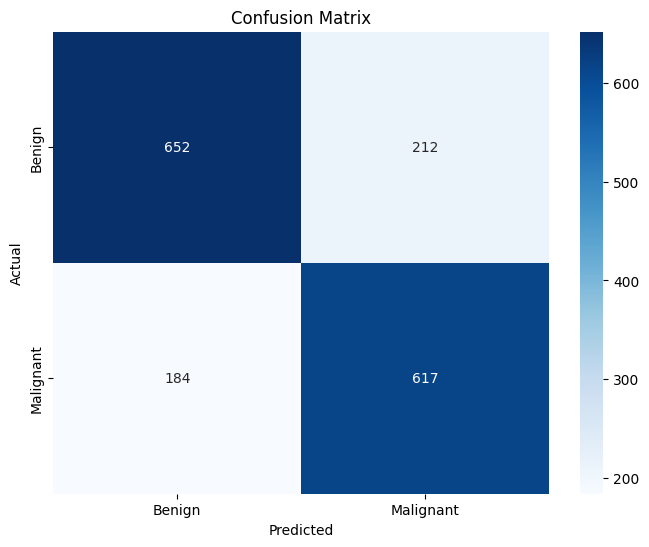

In [147]:
conf_matrix = confusion_matrix(ytest, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [148]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       864
           1       0.66      0.82      0.73       801

    accuracy                           0.71      1665
   macro avg       0.72      0.71      0.71      1665
weighted avg       0.72      0.71      0.71      1665



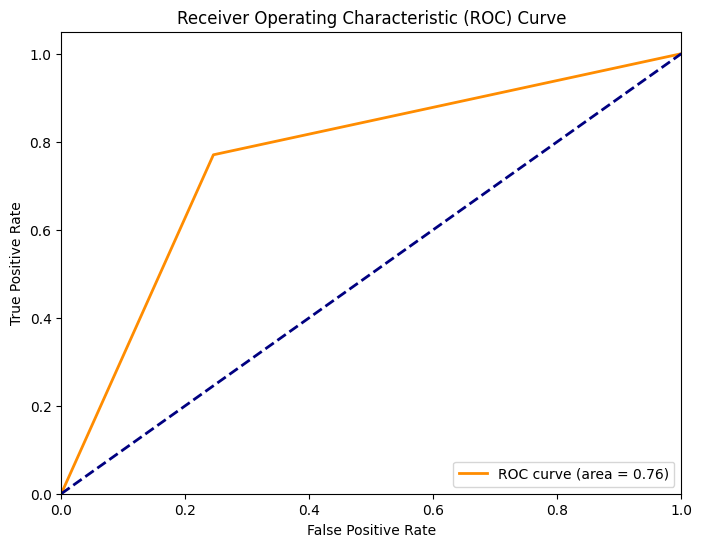

In [149]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [150]:
Gradientboosting = pd.DataFrame({'Model': ["Gradient Boosting"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, y_pred)],
                 'Precision Score': [metrics.precision_score(ytest, y_pred)],
                 'Recall Score': [metrics.recall_score(ytest, y_pred)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, y_pred)],
                  'f1-score': [metrics.f1_score(ytest, y_pred)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, Gradientboosting], ignore_index=True)

In [151]:
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353
2,VGG-16: Transfer Learning,0.713262,0.659617,0.817728,0.709309,0.730212
3,Decision Tree,0.713262,0.659617,0.817728,0.709309,0.730212
4,Gradient Boosting,0.762458,0.744270,0.770287,0.762162,0.757055


##**Support Vector Machine**

In [152]:
from sklearn.svm import SVC
SVM = SVC(kernel= 'rbf', random_state=42) #SVC is the support vector machine classification algorithm
svm = SVM.fit(xtrain,ytrain)  #Fit on training data

In [153]:
# predicting values
y_pred  = svm.predict(xtest)

In [154]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

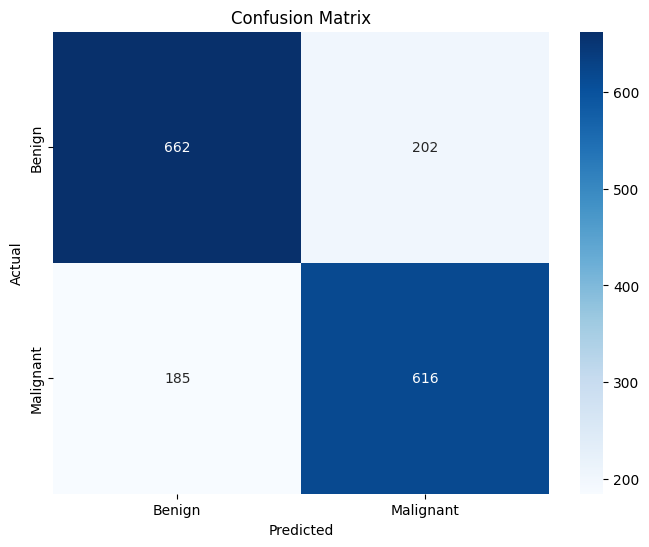

In [155]:
conf_matrix = confusion_matrix(ytest, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [156]:
from sklearn.metrics import classification_report
# accuracy measures by classification_report()
result = classification_report(y_test,Y_pred_classes)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       864
           1       0.66      0.82      0.73       801

    accuracy                           0.71      1665
   macro avg       0.72      0.71      0.71      1665
weighted avg       0.72      0.71      0.71      1665



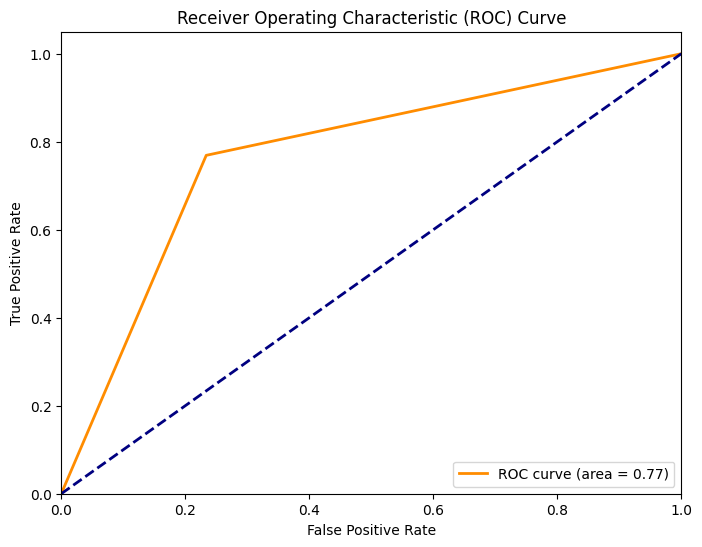

In [157]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [158]:
SVM = pd.DataFrame({'Model': ["Support Vector Machine"],
                     'AUC Score' : [metrics.roc_auc_score(ytest, y_pred)],
                 'Precision Score': [metrics.precision_score(ytest, y_pred)],
                 'Recall Score': [metrics.recall_score(ytest, y_pred)],
                 'Accuracy Score': [metrics.accuracy_score(ytest, y_pred)],
                  'f1-score': [metrics.f1_score(ytest, y_pred)]})

# appending our result table
result_tabulation = pd.concat([result_tabulation, SVM], ignore_index=True)
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Basic Neural Network,0.738374,0.736774,0.712859,0.739339,0.724619
1,Convolutional Neural Network,0.762504,0.743682,0.771536,0.762162,0.757353
2,VGG-16: Transfer Learning,0.713262,0.659617,0.817728,0.709309,0.730212
3,Decision Tree,0.713262,0.659617,0.817728,0.709309,0.730212
4,Gradient Boosting,0.762458,0.744270,0.770287,0.762162,0.757055
5,Support Vector Machine,0.767621,0.753056,0.769039,0.767568,0.760964
